## 1. Upload CSV and Install Dependencies

In [ ]:
# Upload CSV file from your computer
from google.colab import files
uploaded = files.upload()  # Upload coin_features_morphology.csv

Saving coin_features_hough_segmentation.csv to coin_features_hough_segmentation.csv


## 2. Load Data and Preprocess

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

# Load the uploaded CSV
df = pd.read_csv("coin_features_hough_segmentation.csv")

# Separate features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_categorical = to_categorical(y_encoded, num_classes)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42
)

# Save label encoder and scaler for deployment (optional)
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## 3. Build and Train TensorFlow Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
import time
start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)
end = time.time()
print(f"\nTraining Time: {(end - start)/60:.2f} minutes")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1311 - loss: 2.6781 - val_accuracy: 0.2566 - val_loss: 2.2968
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2398 - loss: 2.3730 - val_accuracy: 0.2513 - val_loss: 2.2135
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2584 - loss: 2.2613 - val_accuracy: 0.2646 - val_loss: 2.1174
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2584 - loss: 2.1812 - val_accuracy: 0.2831 - val_loss: 2.0749
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2951 - loss: 2.1107 - val_accuracy: 0.3016 - val_loss: 1.9751
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3002 - loss: 2.0368 - val_accuracy: 0.3519 - val_loss: 1.8990
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3295 - loss: 1.9782 - val_accuracy: 0.3519 - val_loss: 1.8703
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3314 - loss: 1.9309 - val_accuracy: 0.

## 4. Convert to TensorFlow Lite Format

In [ ]:
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open("coin_classifier_hough.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as coin_classifier_hough.tflite")

Saved artifact at '/tmp/tmph5v7fzl2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  134399004716752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134399004720976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134401605568464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134399004719824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134399004720400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134399004720784: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved as coin_classifier_hough.tflite


## 5. Confusion Matrix and ROC Curve

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


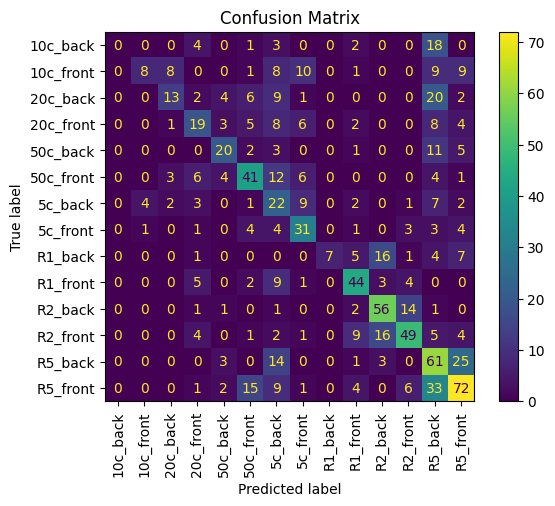

ROC curve skipped: Multi-class ROC needs special handling per class.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (only works properly if 2 classes, otherwise per-class)
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ROC curve skipped: Multi-class ROC needs special handling per class.")

In [ ]:
from google.colab import files

# Download the .tflite file
files.download("coin_classifier_hough.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>